In [66]:
import pandas as pd 
import geopandas as gpd 
import warnings 
import os 
import sys
warnings.filterwarnings("ignore", category=DeprecationWarning)
# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from build_inputs.build_netmob_data import load_netmob_gdf,load_subway_shp

FOLDER_PATH = '../../../../data/rrochas/prediction_validation' 
save_path = f"{FOLDER_PATH}/POIs"
PATH_iris = f'{FOLDER_PATH}/lyon_iris_shapefile'
# Load NetMob gdf
Netmob_gdf,working_zones = load_netmob_gdf(FOLDER_PATH = FOLDER_PATH,
                            data_folder = PATH_iris, 
                            geojson_path = 'NetMob_lyon.geojson',
                            zones_path = 'lyon.shp')
Netmob_gdf_dropped = Netmob_gdf.drop_duplicates(subset = ['tile_id'])  # Some Doubles are exis
subway_station = load_subway_shp(FOLDER_PATH)

## Load POIs, their locations and their Tile-ids : 

### Fonction pour récupérer la localisation des POIs que j'ai enregistré, ainsi que les Tiles_ids NetMob associées.

In [50]:
def build_dict_POI(type_POIs,save_path):
    '''
    Build 'dict_POI' which contain information about POI for each type of POI and each recorded amenity.
    dict_POI['stadium']['Astroballe']['POI'] is a pd.DataFrame with the geometry of the POI
    dict_POI['stadium']['Astroballe']['NetMob_tile_ids'] is a gpd.DataFrame with the NetMob Tile_ids covered by the POI. 

    args:
    -----
    save_path : path to the recorded POIs ()
    >>> ['stadium','nightclub']
    type_POIs : type of recorded POIs saved in 'save_path' 
    >>> f"{FOLDER_PATH}/POIs"
    '''
    dict_POI = {}
    for type_POI in type_POIs:
        dict_POI[type_POI] = {}
        globals()[f"POIs_{type_POI}"] = gpd.read_file(f"{save_path}/gdf_{type_POI}.geojson").rename(columns = {'nom':'name'})
        for name in globals()[f"POIs_{type_POI}"].name:
            POI_name_i = globals()[f"POIs_{type_POI}"][globals()[f"POIs_{type_POI}"].name == name]
            tile_ids = Netmob_gdf_dropped.sjoin(POI_name_i)
            dict_POI[type_POI][name] = {'POI': POI_name_i, 'NetMob_tile_ids':tile_ids}
    return dict_POI


type_POIs = ['stadium','nightclub']
dict_POI = build_dict_POI(type_POIs,save_path)

### Fonction pour récupérer les Tile-ids NetMob + 1 carré autour 

In [74]:
import itertools

def look_around(tile_id:int, step:int = 287):
    ''' Look around the tile-id '''
    
    return [tile_id+step-1, tile_id+step, tile_id+step+1,  # Upper line
            tile_id-1, tile_id, tile_id+1,# Middle Line
            tile_id-step-1, tile_id-step, tile_id-step+1, # Lower Line
            ] 

def expand1(tile_ids:list,set_all_tile_ids:set):
    ''' Look around for each tile-id, and then get the list of unique tile-id'''
    expanded_list = [look_around(id_i) for id_i in tile_ids]
    expanded_list = set(itertools.chain.from_iterable(expanded_list))

    # Keep only existing tile-id (avoid border issues)
    expanded_list = list(set(set_all_tile_ids)&expanded_list)
    return expanded_list

def expand_1_tile_id(dict_POI:dict,set_all_tile_ids:set):
    '''
    From the list of tile-ids associated to a POI, return the 1 square expantion around the list of tile-id

    args:
    -----
    dict_POI generated with build_dict_POI. Contain information about POI for each type of POI and each recorded amenity per type
    >>> dict_POI['stadium']['Astroballe']['POI'] is a pd.DataFrame with the geometry of the POI
    >>> dict_POI['stadium']['Astroballe']['NetMob_tile_ids'] is a gpd.DataFrame with the NetMob Tile_ids covered by the POI. 

    set_all_tile_ids : set of all the possible tile-ids existing in the gdf :
    >>> set_all_tile_ids = set(Netmob_gdf_dropped.tile_id.unique())

    output:
    ------
    dict_tile_ids
    >>> dict_tile_ids[type_POI][amenity]['tile_id'] = tile_ids
    >>> dict_tile_ids[type_POI][amenity]['expanded_tile_id'] = expanded_list
    '''
    dict_tile_ids = {}
    for type_POI in dict_POI.keys():
        dict_tile_ids[type_POI] = {}
        for amenity in dict_POI[type_POI].keys():
            tile_ids = list(dict_POI[type_POI][amenity]['NetMob_tile_ids']['tile_id'])
            expanded_list = expand1(tile_ids,set_all_tile_ids)
            dict_tile_ids[type_POI][amenity] = {'tile_id': tile_ids, 'expanded_tile_id':expanded_list  }

    return dict_tile_ids


set_all_tile_ids = set(Netmob_gdf_dropped.tile_id.unique()) 
dict_tile_ids = expand_1_tile_id(dict_POI,set_all_tile_ids)

### Visualisation de l'expension : 

In [87]:
gdf_plot = gpd.GeoDataFrame()

# Tackle POIs:
for type_POI in dict_POI.keys():
    for amenity in dict_POI[type_POI].keys():
        # Tackle POI
        tile_ids = dict_tile_ids[type_POI][amenity]['tile_id']
        POI_i = Netmob_gdf_dropped[Netmob_gdf_dropped.tile_id.isin(tile_ids)][['tile_id','geometry']]
        POI_i['type'] = "POI"
        POI_i['name'] = amenity

        # Tackle expanded POI 
        expanded_tile_ids = dict_tile_ids[type_POI][amenity]['expanded_tile_id']
        expanded_POI = Netmob_gdf_dropped[Netmob_gdf_dropped.tile_id.isin(expanded_tile_ids)][['tile_id','geometry']]
        expanded_POI['type'] = "POI_expanded"
        expanded_POI['name'] = amenity

        gdf_plot = gpd.GeoDataFrame(pd.concat([gdf_plot,expanded_POI,POI_i]))

# Tackle Subway Station:
netmob_subway = Netmob_gdf_dropped.sjoin(subway_station)
for idx,row in netmob_subway.iterrows():
    expanded_tile_ids = expand1(tile_ids=[row.tile_id],set_all_tile_ids=set_all_tile_ids)
    n = len(expanded_tile_ids)

    # Tackle subway station : 
    gdf_station = netmob_subway[netmob_subway.tile_id == row.tile_id][['tile_id','geometry']]
    gdf_station['type'] = 'station'
    gdf_station['name'] = row.COD_TRG   

    # Tackle expanded subway station : 
    expanded_station = Netmob_gdf_dropped[Netmob_gdf_dropped.tile_id.isin(expanded_tile_ids)][['tile_id','geometry']]
    expanded_station['type'] = 'station_expanded'
    expanded_station['name'] = row.COD_TRG
    gdf_plot = gpd.GeoDataFrame(pd.concat([gdf_plot,expanded_station,gdf_station]))

gdf_plot.explore('type',cmap = 'summer')

In [80]:
subway_station

,COD_TRG,geometry
0,AMP,POINT (4.82921 45.75311)
1,BEL,POINT (4.83340 45.75726)
2,BRO,POINT (4.85943 45.76689)
3,COR,POINT (4.83581 45.76345)
4,CUI,POINT (4.83250 45.78526)
5,CUS,POINT (4.90029 45.76571)
6,FLA,POINT (4.89005 45.76759)
7,GOR,POINT (4.80549 45.76643)
8,BLA,POINT (4.87895 45.74289)
9,GRA,POINT (4.88219 45.76904)


In [62]:
expanded_POI

,tile_id,INSEE_COM,NOM_COM,NOM_IRIS,geometry
16672,54926,69387.0,Lyon 7e Arrondissement,Tony Garnier,"POLYGON ((4.82900 45.72685, 4.82904 45.72775, ..."
16673,54927,69387.0,Lyon 7e Arrondissement,Tony Garnier,"POLYGON ((4.83028 45.72682, 4.83032 45.72772, ..."
16674,54928,69387.0,Lyon 7e Arrondissement,Cité Jardin,"POLYGON ((4.83157 45.72680, 4.83161 45.72770, ..."
16863,55213,69387.0,Lyon 7e Arrondissement,Tony Garnier,"POLYGON ((4.82904 45.72775, 4.82908 45.72865, ..."
16864,55214,69387.0,Lyon 7e Arrondissement,Tony Garnier,"POLYGON ((4.83032 45.72772, 4.83036 45.72862, ..."
16865,55215,69387.0,Lyon 7e Arrondissement,Cité Jardin,"POLYGON ((4.83161 45.72770, 4.83165 45.72859, ..."
17054,55500,69387.0,Lyon 7e Arrondissement,Tony Garnier,"POLYGON ((4.82908 45.72865, 4.82912 45.72955, ..."
17055,55501,69387.0,Lyon 7e Arrondissement,Marcel Mérieux,"POLYGON ((4.83036 45.72862, 4.83040 45.72952, ..."
17056,55502,69387.0,Lyon 7e Arrondissement,Cité Jardin,"POLYGON ((4.83165 45.72859, 4.83169 45.72949, ..."


In [3]:
save_path = f"{FOLDER_PATH}/POIs"
POIs_stadium = gpd.read_file(f"{save_path}/gdf_stadium.geojson")

In [4]:
Lou_rugby = POIs_stadium[POIs_stadium.nom == 'Matmut Stadium Gerland']
Astroballe = POIs_stadium[POIs_stadium.nom == 'Astroballe']
Groupama = POIs_stadium[POIs_stadium.nom == 'Groupama Stadium']

tile_ids_Lou_rugby = Netmob_gdf_dropped.sjoin(Lou_rugby)
tile_ids_Astroballe = Netmob_gdf_dropped.sjoin(Astroballe)
tile_ids_Groupama = Netmob_gdf_dropped.sjoin(Groupama)

stadium2tile_ids = {'Lou_rugby':list(tile_ids_Lou_rugby.tile_id),
                    'Astroballe':list(tile_ids_Astroballe.tile_id),
                    'Groupama':list(tile_ids_Groupama.tile_id)
                    }

## Load POIs Nightclub and their location : 

In [5]:
POIs_nightclub = gpd.read_file(f"{save_path}/gdf_nightclub.geojson")

Ninkasi_Kao = POIs_nightclub[POIs_nightclub.name == 'Ninkasi Kao']
Azar_Club = POIs_nightclub[POIs_nightclub.name == 'Azar Club']
Le_Sucre = POIs_nightclub[POIs_nightclub.name == 'Le Sucre']

tile_ids_Ninkasi_Kao = Netmob_gdf_dropped.sjoin(Ninkasi_Kao)
tile_ids_Azar_Club = Netmob_gdf_dropped.sjoin(Azar_Club)
tile_ids_Le_Sucre = Netmob_gdf_dropped.sjoin(Le_Sucre)

nightclub2tile_ids = {'Ninkasi_Kao':list(tile_ids_Ninkasi_Kao.tile_id),
                    'Azar_Club':list(tile_ids_Azar_Club.tile_id),
                    'Le_Sucre':list(tile_ids_Le_Sucre.tile_id)
}

## Ploting on folium Map:

In [25]:
import folium 
subway_station['type'] = 'station'
POIs_stadium['type'] = 'POIs_stadium'
POIs_nightclub['type'] = 'POIs_nightclub'


gdf = gpd.GeoDataFrame(pd.concat([subway_station[['geometry','type']],
                                  POIs_stadium[['geometry','type']],
                                  POIs_nightclub[['geometry','type']],
                                  ],ignore_index = True))

# Affichage avec styles personnalisés
gdf.explore('type',
            cmap = 'viridis',
            #marker_type = 'circle',
            marker_kwds=dict(radius=15)
)

In [30]:
subway_station['type'] = 'station'

POIs['type'] = 'POI'
tile_ids_Lou_rugby['type'] = 'tile_ids_of_POI'
tile_ids_Astroballe['type'] = 'tile_ids_of_POI'
tile_ids_Groupama['type'] = 'tile_ids_of_POI'

POIs_nightclub['type'] = 'POI'
tile_ids_Ninkasi_Kao['type'] = 'tile_ids_of_POI'
tile_ids_Azar_Club['type'] = 'tile_ids_of_POI'
tile_ids_Le_Sucre['type'] = 'tile_ids_of_POI'

gdf = gpd.GeoDataFrame(pd.concat([subway_station[['geometry','type']],
                                  POIs[['geometry','type']],
                                  tile_ids_Lou_rugby[['geometry','type']],
                                  tile_ids_Astroballe[['geometry','type']],
                                  tile_ids_Groupama[['geometry','type']],

                                  POIs_nightclub[['geometry','type']],
                                  tile_ids_Ninkasi_Kao[['geometry','type']],
                                  tile_ids_Azar_Club[['geometry','type']],
                                  tile_ids_Le_Sucre[['geometry','type']],

                                  ],ignore_index = True))

# Affichage avec styles personnalisés
gdf.explore('type',
            marker_kwds=dict(marker_type = 'circle', radius=15,color = 'red', fill_color = 'red')
)

## Load Time-Serie on these specific location :

Tackle Apple_Video DL at Lou_rugby


<Axes: >

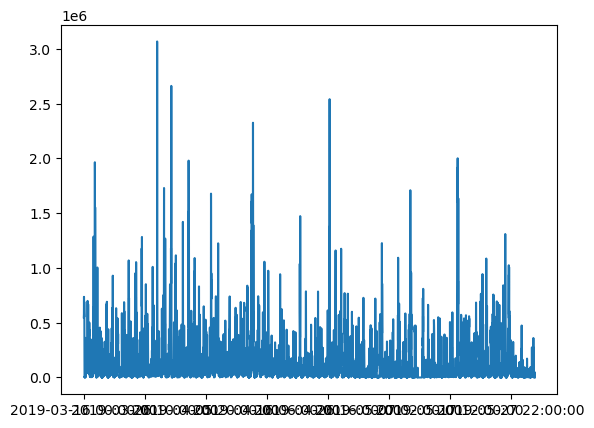

In [62]:
FOLDER_PATH = '../../../../data/rrochas/prediction_validation' 
app : 'Instagram'
transfer_mode = 'DL'
stadium = 'Lou_rugby'
folder_path_app = f"{FOLDER_PATH}/POIs/stadium/{app}"

print(f"Tackle {app} {transfer_mode} at {stadium}")
serie = pd.read_csv(f"{folder_path_app}/df_{stadium}_{transfer_mode}.csv",index_col = 0)
serie = serie.sum(axis=1)